# River as a shapefile (raw format)

In [1]:
import geopandas as gpd

shapefile = gpd.read_file("edges.shp")

# TEST
# shapefile = shapefile[shapefile['rid'].isin(range(6))]
shapefile.head()

,rid,netID,upDist,shreve,Length,addfunccol,geometry
0,1.0,1,1.000000,282.0,1.000000,1.000000,"LINESTRING (0.00000 1.00000, 0.00000 0.00000)"
1,2.0,1,1.960106,2.0,0.960106,0.007092,"LINESTRING (0.42592 1.86046, 0.00000 1.00000)"
2,3.0,1,1.980141,280.0,0.980141,0.992908,"LINESTRING (0.16583 1.96601, 0.00000 1.00000)"
3,4.0,1,3.009663,1.0,1.049557,0.003546,"LINESTRING (1.07174 2.68780, 0.42592 1.86046)"
4,5.0,1,2.949200,1.0,0.989094,0.003546,"LINESTRING (1.12110 2.56405, 0.42592 1.86046)"


rid - unique identifier for river segment\
netID - river network ID, when dealing with multiple river outlets\
upDist - distance upstream from outlet (from the most upstream point on line)\
shreve - segment weighting based on Shreve's order\
addfunccol - additive function column, normalised shreve's order (used for weighting segments, a proxy for water volume)

<Axes: >

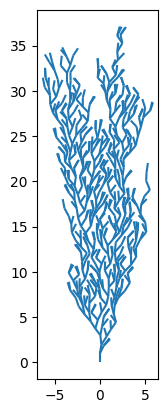

In [2]:
shapefile.plot()

## River as graph (NetworkX)

In [3]:
# extract point information from shapely object: type(shapefile.geometry[0])
shapefile["points"] = shapefile.apply(lambda l: list(l["geometry"].coords), axis=1)
shapefile[["points_from", "points_to"]] = shapefile["points"].to_list()

# create a unique identifier for the start/end points of an edge
unique_locations = sorted(
    list(set([item for sublist in shapefile.points.to_list() for item in sublist]))
)
PID_GPT = {i: unique_locations[i] for i in range(len(unique_locations))}
GPT_PID = {v: k for k, v in PID_GPT.items()}

# map from geographic point, GPT, to unique node identifier, PID
shapefile["pid_from"] = shapefile["points_from"].apply(lambda x: GPT_PID[x])
shapefile["pid_to"] = shapefile["points_to"].apply(lambda x: GPT_PID[x])

In [4]:
len(unique_locations)

635

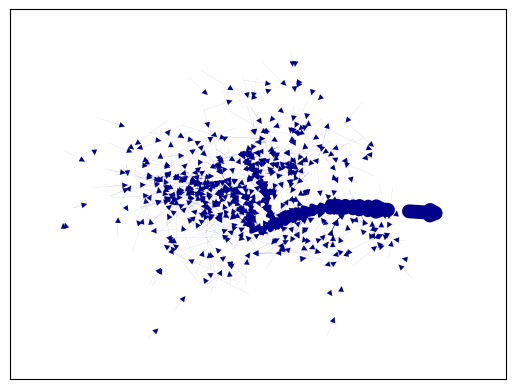

In [5]:
import networkx as nx

# encode as networkx object and plot
G = nx.DiGraph()
G.add_weighted_edges_from(
    list(zip(shapefile.pid_from, shapefile.pid_to, shapefile.addfunccol * 10))
)
# adding edges in the form: G.add_weighted_edges_from([(1, 2, 0.5), (3, 1, 1.75)])
pos = nx.spring_layout(G)
widths = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=widths.keys(),
    width=list(widths.values()),
    edge_color="darkblue",
    alpha=1,
)
# nodelist = G.nodes()
# nx.draw_networkx_nodes(G,pos,
#                        nodelist=nodelist,
#                        node_size=1500,
#                        node_color='black',
#                        alpha=0.7)
# nx.draw_networkx_labels(G, pos=pos,
#                         labels=dict(zip(nodelist,nodelist)),
#                         font_color='white')

In [6]:
df = shapefile[
    ["rid", "upDist", "shreve", "Length", "addfunccol", "pid_from", "pid_to"]
].copy()
# df['upstream_rid'] = None
# df = df.sort_values('shreve')
# df['endpoint_rid'] = df.apply(lambda x: [], axis=1)

In [7]:
def get_upstream_rids(row, df):
    upstream_rids = []
    up = df[df["pid_to"] == row["pid_from"]]

    while len(up) > 0:
        new_pids = list(up["pid_from"])
        upstream_rids.extend(up["rid"])
        up = df[df["pid_to"].isin(new_pids)]

    return upstream_rids


df["upstream_rids"] = df.apply(lambda x: get_upstream_rids(x, df), axis=1)

In [8]:
len(df[df["upstream_rids"].str.len() == 0])

282

In [9]:
len(
    df[(df["shreve"] == 1) & (df["upstream_rids"].str.len() > 0)]
)  # when single line segments join to other single line segments

39

In [10]:
offsets = df[df["upstream_rids"].str.len() == 0]
offsets = offsets.sort_values("pid_from")
offsets["x_offset"] = [i / len(offsets) for i in range(len(offsets))]

OFFSETS = {rid: x_offset for rid, x_offset in zip(offsets["rid"], offsets["x_offset"])}

In [11]:
def get_offset(df):
    # for the endpoints
    if len(df["upstream_rids"]) == 0:
        return OFFSETS[df["rid"]]

    # otherwise search the upstream rids for the most left-sided offset
    x_offsets = [
        OFFSETS[k] if k in OFFSETS.keys() else 100 for k in df["upstream_rids"]
    ]
    return min(x_offsets)

In [12]:
df["x_offset"] = df.apply(get_offset, axis=1)
df

,rid,upDist,shreve,Length,addfunccol,pid_from,pid_to,upstream_rids,x_offset
0,1.0,1.000000,282.0,1.000000,1.000000,301,300,"[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...",0.000000
1,2.0,1.960106,2.0,0.960106,0.007092,339,301,"[4.0, 5.0]",0.602837
2,3.0,1.980141,280.0,0.980141,0.992908,319,301,"[6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 1...",0.000000
3,4.0,3.009663,1.0,1.049557,0.003546,389,339,[],0.602837
4,5.0,2.949200,1.0,0.989094,0.003546,392,339,[],0.606383
...,...,...,...,...,...,...,...,...,...
629,630.0,37.367503,1.0,1.033987,0.003546,9,12,[],0.017730
630,631.0,22.265709,1.0,1.089175,0.003546,626,631,"[633.0, 634.0]",0.989362
631,632.0,37.403430,1.0,1.014919,0.003546,2,8,[],0.003546
632,633.0,23.215593,1.0,0.949883,0.003546,628,626,[634.0],0.989362


<Axes: >

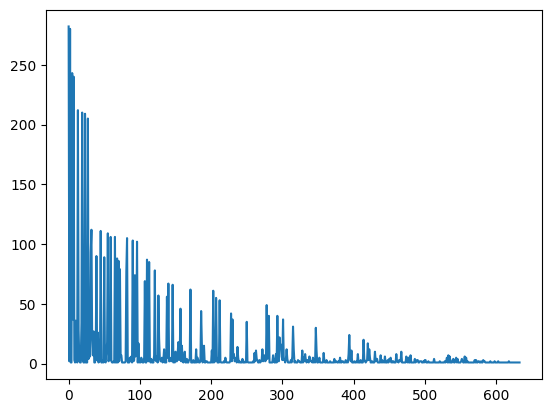

In [13]:
df["shreve"].plot()

## River domain representation (continuous)

In [ ]:
# create high-coverage continous domain representation
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.plotting import plot_polygon, plot_points

fig = plt.figure(1, dpi=90)

# 1: valid polygon
ax = fig.add_subplot()

ext = [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)]
int = [(0, 2), (0, 1.75), (1.75, 1.75), (2, 2), (0, 2)]
polygon = Polygon(ext, [int])

plot_polygon(polygon, ax=ax, add_points=False, color="b")
plt.show()

In [ ]:
polygon.length

In [ ]:
list(polygon.interiors)

In [ ]:
# add points, calculate distance